# Definição do Problema

## Objetivo

Por meio de redes neurais artificiais convolucionais (CNNs), busca-se realizar classificação multiclasse de imagens contendo diferentes animais.

## Conjunto de dados

O conjunto pode ser obtido [aqui](https://www.kaggle.com/datasets/alessiocorrado99/animals10).

Há dez tipos distintos de animais, sendo eles o cão, o cavalo, o elefante, a borboleta, a galinha, o gato, a vaca, a ovelha, a aranha e o esquilo, cada qual contendo suas respectivas variantes macho e fêmea. Trata-se de um conjunto com cerca de 26k exemplos, previamente rotulados, homogeneamente distribuído entre sete das dez classes, enquanto três delas apresentam quantia de instâncias significativamente superior às demais (vide gráfico na seção de "Leitura do conjunto de dados"). Ainda, em relação à composição desses dados, os exemplos se caracterizam, disjuntamente, como imagens conceituais, fotos, pinturas digitais e demais tipos visuais, embora a distribuição seja desconhecida para esse caso -- dada a falta de rotulação nesse sentido.

A saber, as imagens capturam os animais em diferentes ângulos, por vezes priorizando uma ou outra característica deles -- como, por exemplo, as asas para a borboleta, e as patas de um elefante, que visualmente se diferem em relação aos corpos dos demais animais. Além disso, algumas imagens contêm diversas ocorrências de um mesmo animal, como uma foto contendo uma ninhada de cães. Quanto aos planos de fundo, não há constância para as classes, de tal maneira que se torne seguro classificar tais animais sem ter de recorrer à análise do ambiente para isso; por exemplo, há fotos de esquilos em árvores e em solos coberto por folhas, mas também em ambientes urbanos e em telas planas.

Por fim, a divisão do conjunto de dados é realizada de forma pseudoaleatória, com semente fixa, por meio da técnica de Holdout. Desse modo, o referido conjunto é dividido nos subconjuntos de treino, de validação e de teste, cada qual com 80%, 10% e 10% da quantia absoluta de exemplos respectivamente. Para tanto, uma ferramenta utilitária do Keras será utilizada.

## Conceituação

Trata-se de um problema de classificação multiclasse por meio de aprendizado supervisionado. Ainda, por utilizar redes neurais artificiais, caracteriza-se como um paradigma conexionista, que será descrito por instâncias e aprenderá de forma incremental. Por conseguinte, não há descrição por meio de tabelas atributo-valor: ao invés disso, as características dos dados serão seus três canais (RGB), que são representados por matrizes de pixels, de modo aos modelos neurais inferirem novas características e realizarem o processo classificativo a partir de suas hipóteses.

## Plano de execução

Após a leitura e o pré-processamento dos dados, serão treinados cinco diferentes modelos neurais: um modelo denso, um modelo convolucional com poucas camadas, e as arquiteturas Xception, ResNet50 e InceptionV3. Para cada modelo, serão tomados os resultados que, ao final, serão comparados entre si. Ainda, será feita uma abordagem de visualização para compreensão do modo de extração de características por parte dos modelos convolucionais.


# Aquisição do conjunto de dados

Para execução em ambiente Google Colaboratory.

Para execução local, faça o download e o desempacotamento da base de dados no diretório deste notebook.

In [3]:
# Download do pacote do Kaggle
! pip install -q kaggle

In [ ]:
# Em sua conta do Kaggle, gere uma chave de API: isso fornecerá 
# um arquivo "kaggle.json". Faça upload dele nesta célula
from google.colab import files
files.upload()

In [5]:
# Processamento da licença
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Importação do conjunto de dados
! kaggle datasets download 'alessiocorrado99/animals10'

 98% 572M/586M [00:04<00:00, 158MB/s]
100% 586M/586M [00:05<00:00, 122MB/s]


In [7]:
%%capture

# Unzip dos dados
! mkdir data
! unzip animals10.zip -d data

# Dependências

In [28]:
# Para ciência de dados
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from sklearn.model_selection import train_test_split

# Manipulação de arquivos
import os

# Para mostrar gráficos e imagens
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
plt.style.use("bmh")

In [29]:
# Verifica se a GPU está sendo utilizada e aplica a expansão memorial
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Quantia de GPUs disponíveis:", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Quantia de GPUs disponíveis: 1


# Leitura do conjunto de dados

In [9]:
# Tradução de nomes presente em "./data/translate.py"
translation_mapper = {
    "cane": "dog", 
    "cavallo": "horse", 
    "elefante": "elephant", 
    "farfalla": "butterfly", 
    "gallina": "chicken", 
    "gatto": "cat", 
    "mucca": "cow", 
    "pecora": "sheep", 
    "ragno": "spider",
    "scoiattolo": "squirrel"
}

# Para mapeamento das labels
label_mapper = dict([(name, idx) for idx, name in enumerate(translation_mapper)])
label_unmapper = dict([(idx, name) for idx, name in enumerate(translation_mapper.values())])

# Diretório das imagens
IMG_DIR_PATH = "./data/raw-img/"

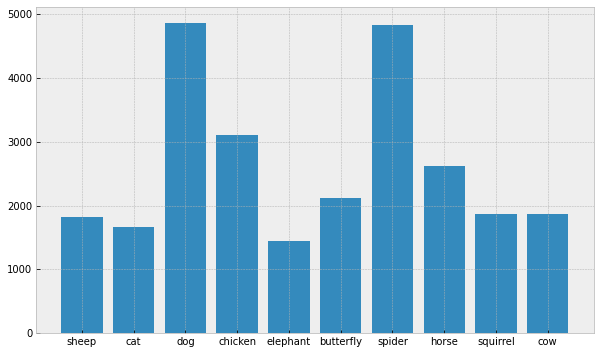

Total de elementos: 26179


In [10]:
# Visualização da distribuição de classes
class_names = os.listdir(IMG_DIR_PATH)
class_sizes = []
for class_name in class_names:
    class_sizes.append(len(os.listdir(IMG_DIR_PATH + class_name)))
class_names = list(map(translation_mapper.get, class_names))
plt.figure(figsize=(10,6))
x = np.arange(len(class_names))
plt.bar(x, class_sizes)
plt.xticks(x, class_names)
plt.show()
print("Total de elementos: {}".format(np.sum(class_sizes)))

In [11]:
# Para manipulação dos dados
SEED = 16
IMAGE_SIZE = (224, 224)
load_dataset = lambda subset, split: tf.keras.utils.image_dataset_from_directory (
    IMG_DIR_PATH,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    subset=subset, 
    validation_split=split, 
)
train_data = load_dataset("training", 0.2)
val_data = load_dataset("validation", 0.2)
train_size = len(train_data.file_paths)
test_size = int(len(val_data.file_paths)/2)
test_data = val_data.take(test_size)
val_data.skip(test_size)
val_size = test_size
print("\nUsing {}, {} and {} files for training, validation and test respectively.".format(train_size, val_size, test_size))

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.

Using 20944, 2617 and 2617 files for training, validation and test respectively.


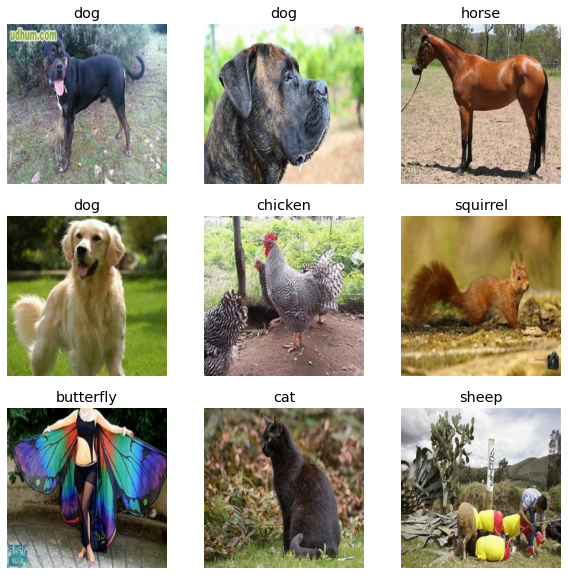

In [ ]:
# Exemplo de imagens (possivelmente distorcidas devido ao redimensionamento)
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label_unmapper[int(labels[i])])
        plt.axis("off")

# Treinamento dos modelos

In [12]:
# Função de perda e otimizador a serem utilizados
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam, SGD

# Para guardas os resultados
results = {}
DENSE = "d"
CONVOLUTIONAL = "c"
XCEPTION = "x"
RESNET50 = "r"
INCEPTIONV3 = "i"

# Tensor de entrada
input_tensor = keras.layers.Input(shape=(*IMAGE_SIZE, 3))

# Quantia de classes
num_classes = len(label_mapper)

## Baseline: RNA densa

In [ ]:
# Camadas necessárias
from keras.layers import Input, Flatten, Dense

# Criação do modelo
def create_dense_model(input_tensor, num_labels, loss, optimizer, name="model"):

    # Entrada
    inputs = input_tensor

    # Camadas Densas
    x = Flatten()(inputs)
    x = Dense(units=1024, activation="relu")(x)
    x = Dense(units=512, activation="relu")(x)
    x = Dense(units=256, activation="relu")(x)
    x = Dense(units=64, activation="relu")(x)
    outputs = Dense(units=num_labels, activation="softmax")(x)

    # Finalização
    model = Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

# Modelo Denso
loss_function = SparseCategoricalCrossentropy()
model_optimizer = Adam(learning_rate = 0.00025, clipnorm = 1.0)
dense_model = create_dense_model(input_tensor, num_classes, loss_function, model_optimizer, name="dense_model")

# Sumarização
dense_model.summary()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 flatten_6 (Flatten)         (None, 150528)            0         
                                                                 
 dense_29 (Dense)            (None, 1024)              154141696 
                                                                 
 dense_30 (Dense)            (None, 512)               524800    
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dense_32 (Dense)            (None, 64)                16448     
                                                                 
 dense_33 (Dense)            (None, 10)                

In [ ]:
# Treino
epochs = 1
dense_model.fit (
    train_data, 
    validation_data = val_data, 
    epochs = epochs, 
)

655/655 [==============================] - 53s 81ms/step - loss: 53.4147 - accuracy: 0.1763 - val_loss: 2.2867 - val_accuracy: 0.1927


In [ ]:
# Teste
results[DENSE] = dense_model.evaluate(test_data)
print("loss = {:.2f}; accuracy = {:.2f}%".format(results[DENSE][0], results[DENSE][1] * 100.0))

164/164 [==============================] - 9s 53ms/step - loss: 2.2867 - accuracy: 0.1927
loss = 2.29; accuracy = 19.27%


## Modelo Convolucional

In [55]:
# Camadas necessárias
from keras.layers import Input, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Criação do modelo
def create_conv_model(input_tensor, num_labels, loss, optimizer, name="model"):

    # Entrada
    inputs = input_tensor

    # Primeira seção
    x = Conv2D(32, kernel_size=(3, 3), padding='same')(inputs)
    x = Activation('relu')(x)
    x = Conv2D(32,kernel_size=(3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Segunda seção
    x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, kernel_size=(3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Seção final
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_labels)(x)
    outputs = Activation(tf.nn.softmax)(x)

    # Finalização
    model = Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

# Modelo Denso
loss_function = SparseCategoricalCrossentropy()
model_optimizer = Adam(learning_rate = 0.00025, clipnorm = 1.0)
conv_model = create_conv_model(input_tensor, num_classes, loss_function, model_optimizer, name="conv_model")

# Sumarização
conv_model.summary()

Model: "conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 activation_94 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 conv2d_95 (Conv2D)          (None, 222, 222, 32)      9248      
                                                                 
 activation_95 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                        

In [56]:
# Treino
epochs = 8
conv_model.fit (
    train_data, 
    validation_data = val_data, 
    epochs = epochs, 
    batch_size = 64,
)

Epoch 1/8
516/655 [======================>.......] - ETA: 19s - loss: 8.7825 - accuracy: 0.3144

KeyboardInterrupt: ignored

In [ ]:
# Teste
results[CONVOLUTIONAL] = conv_model.evaluate(test_data)
print("loss = {:.2f}; accuracy = {:.2f}%".format(results[CONVOLUTIONAL][0], results[CONVOLUTIONAL][1] * 100.0))

164/164 [==============================] - 8s 49ms/step - loss: 1.2643 - accuracy: 0.5971
loss = 1.26; accuracy = 59.71%


## Modelos pré-definidos

In [18]:
# Camadas necessárias para a transferência de aprendizado
from keras.layers import Dense, GlobalAveragePooling2D

# Modelos originais
from keras.applications.xception import Xception
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3

### Xception

In [ ]:
# Modelo original
base_model = Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)

# Adição de camadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Novo modelo
xception_model = Model(inputs=base_model.input, outputs=outputs)

# Congelamento das camadas convolucionais (para treinar somente as camadas superiores)
for layer in base_model.layers:
    layer.trainable = False

# Compilação
loss_function = SparseCategoricalCrossentropy()
model_optimizer = Adam(learning_rate = 0.00025, clipnorm = 1.0)
xception_model.compile(optimizer=model_optimizer, loss=loss_function, metrics=['accuracy'])

In [ ]:
# Treino das camadas superiores
epochs = 1
xception_model.fit (
    train_data, 
    validation_data = val_data, 
    epochs = epochs, 
)

655/655 [==============================] - 112s 167ms/step - loss: 3.5836 - accuracy: 0.2935 - val_loss: 2.2418 - val_accuracy: 0.3501


In [ ]:
# Visualização das camadas (para escolher até onde descongelar)
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_9
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_400
13 block2_pool
14 batch_normalization_384
15 add_24
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_401
23 block3_pool
24 batch_normalization_385
25 add_25
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_402
33 block4_pool
34 batch_normalization_386
35 add_26
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_27
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn


In [ ]:
# Descongelamento das orimeiras camadas
for layer in xception_model.layers[:105]:
   layer.trainable = False
for layer in xception_model.layers[105:]:
   layer.trainable = True

# Recompilação
loss_function = SparseCategoricalCrossentropy()
model_optimizer = SGD(learning_rate=0.0001, momentum=0.9)
xception_model.compile(optimizer=model_optimizer, loss=loss_function, metrics=['accuracy'])

# Treino
epochs = 1
xception_model.fit (
    train_data, 
    validation_data = val_data, 
    epochs = epochs, 
)

655/655 [==============================] - 145s 217ms/step - loss: 2.1692 - accuracy: 0.2464 - val_loss: 2.1363 - val_accuracy: 0.2638


In [ ]:
# Teste
results[XCEPTION] = xception_model.evaluate(test_data)
print("loss = {:.2f}; accuracy = {:.2f}%".format(results[XCEPTION][0], results[XCEPTION][1] * 100.0))

164/164 [==============================] - 22s 133ms/step - loss: 2.1363 - accuracy: 0.2638
loss = 2.14; accuracy = 26.38%


### ResNet50

In [ ]:
# Modelo original
base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)

# Adição de camadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Novo modelo
resnet_model = Model(inputs=base_model.input, outputs=outputs)

# Congelamento das camadas convolucionais (para treinar somente as camadas superiores)
for layer in base_model.layers:
    layer.trainable = False

# Compilação
loss_function = SparseCategoricalCrossentropy()
model_optimizer = Adam(learning_rate = 0.00025, clipnorm = 1.0)
resnet_model.compile(optimizer=model_optimizer, loss=loss_function, metrics=['accuracy'])

In [ ]:
# Treino das camadas superiores
epochs = 1
resnet_model.fit (
    train_data, 
    validation_data = val_data, 
    epochs = epochs, 
)

655/655 [==============================] - 89s 130ms/step - loss: 0.2915 - accuracy: 0.9099 - val_loss: 0.2071 - val_accuracy: 0.9364


In [ ]:
# Visualização das camadas (para escolher até onde descongelar)
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_9
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [ ]:
# Descongelamento das orimeiras camadas
for layer in resnet_model.layers[:154]:
   layer.trainable = False
for layer in resnet_model.layers[154:]:
   layer.trainable = True

# Recompilação
loss_function = SparseCategoricalCrossentropy()
model_optimizer = SGD(learning_rate=0.0001, momentum=0.9)
resnet_model.compile(optimizer=model_optimizer, loss=loss_function, metrics=['accuracy'])

# Treino
epochs = 1
resnet_model.fit (
    train_data, 
    validation_data = val_data, 
    epochs = epochs, 
)

655/655 [==============================] - 100s 147ms/step - loss: 0.1291 - accuracy: 0.9612 - val_loss: 0.1635 - val_accuracy: 0.9524


In [ ]:
# Teste
results[RESNET50] = resnet_model.evaluate(test_data)
print("loss = {:.2f}; accuracy = {:.2f}%".format(results[RESNET50][0], results[RESNET50][1] * 100.0))

164/164 [==============================] - 17s 101ms/step - loss: 0.1635 - accuracy: 0.9524
loss = 0.16; accuracy = 95.24%


### InceptionV3

In [19]:
# Modelo original
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

# Adição de camadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Novo modelo
inception_model = Model(inputs=base_model.input, outputs=outputs)

# Congelamento das camadas convolucionais (para treinar somente as camadas superiores)
for layer in base_model.layers:
    layer.trainable = False

# Compilação
loss_function = SparseCategoricalCrossentropy()
model_optimizer = Adam(learning_rate = 0.00025, clipnorm = 1.0)
inception_model.compile(optimizer=model_optimizer, loss=loss_function, metrics=['accuracy'])

87910968/87910968 [==============================] - 1s 0us/step


In [20]:
# Treino das camadas superiores
epochs = 4
inception_model.fit (
    train_data, 
    validation_data = val_data, 
    epochs = epochs, 
)

Epoch 1/4
655/655 [==============================] - 83s 106ms/step - loss: 5.3265 - accuracy: 0.2546 - val_loss: 3.7544 - val_accuracy: 0.2078
Epoch 2/4
655/655 [==============================] - 68s 103ms/step - loss: 2.5088 - accuracy: 0.3102 - val_loss: 2.2653 - val_accuracy: 0.2980
Epoch 3/4
655/655 [==============================] - 66s 101ms/step - loss: 1.9702 - accuracy: 0.3408 - val_loss: 1.9060 - val_accuracy: 0.3333
Epoch 4/4
655/655 [==============================] - 67s 102ms/step - loss: 1.8073 - accuracy: 0.3769 - val_loss: 1.7892 - val_accuracy: 0.3788


In [44]:
# Visualização das camadas (para escolher até onde descongelar)
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [23]:
# Descongelamento das orimeiras camadas
for layer in inception_model.layers[:249]:
   layer.trainable = False
for layer in inception_model.layers[249:]:
   layer.trainable = True

# Recompilação
loss_function = SparseCategoricalCrossentropy()
model_optimizer = SGD(learning_rate=0.0001, momentum=0.9)
inception_model.compile(optimizer=model_optimizer, loss=loss_function, metrics=['accuracy'])

# Treino
epochs = 8
inception_model.fit (
    train_data, 
    validation_data = val_data, 
    epochs = epochs, 
)

Epoch 1/8
655/655 [==============================] - 83s 120ms/step - loss: 2.1309 - accuracy: 0.2345 - val_loss: 2.0742 - val_accuracy: 0.2777
Epoch 2/8
655/655 [==============================] - 83s 126ms/step - loss: 2.0533 - accuracy: 0.2857 - val_loss: 2.0064 - val_accuracy: 0.2938
Epoch 3/8
655/655 [==============================] - 82s 124ms/step - loss: 1.9932 - accuracy: 0.2933 - val_loss: 1.9599 - val_accuracy: 0.3058
Epoch 4/8
655/655 [==============================] - 80s 122ms/step - loss: 1.9467 - accuracy: 0.3106 - val_loss: 1.9138 - val_accuracy: 0.3299
Epoch 5/8
655/655 [==============================] - 81s 123ms/step - loss: 1.9006 - accuracy: 0.3331 - val_loss: 1.8733 - val_accuracy: 0.3471
Epoch 6/8
655/655 [==============================] - 81s 124ms/step - loss: 1.8569 - accuracy: 0.3476 - val_loss: 1.8349 - val_accuracy: 0.3605
Epoch 7/8
655/655 [==============================] - 80s 122ms/step - loss: 1.8129 - accuracy: 0.3606 - val_loss: 1.7968 - val_accuracy:

In [24]:
# Teste
results[INCEPTIONV3] = inception_model.evaluate(test_data)
print("loss = {:.2f}; accuracy = {:.2f}%".format(results[INCEPTIONV3][0], results[INCEPTIONV3][1] * 100.0))

164/164 [==============================] - 13s 80ms/step - loss: 1.7697 - accuracy: 0.3891
loss = 1.77; accuracy = 38.91%


# Resultados

In [13]:
# TEMPORÁRIO (PARA TESTES)
results = {
    DENSE: [0.25, 0.1], 
    CONVOLUTIONAL: [0.18, 0.6], 
    XCEPTION: [0.14, 0.8], 
    RESNET50: [0.12, 0.85], 
    INCEPTIONV3: [0.09, 0.92], 
}

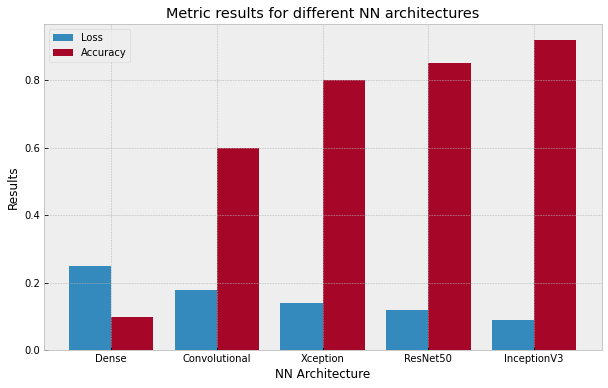

In [15]:
# Preparação
plt.figure(figsize=(10,6))
numeric_results = np.array(list(results.values()))
labels = ["Dense", "Convolutional", "Xception", "ResNet50", "InceptionV3"]
x = np.arange(numeric_results.shape[0])

# Barras
plt.bar(x-0.2, numeric_results[:,0], 0.4, label = 'Loss')
plt.bar(x+0.2, numeric_results[:,1], 0.4, label = 'Accuracy')

# Eixos
plt.xticks(x, labels)
plt.xlabel("NN Architecture")
plt.ylabel("Results")
plt.title("Metric results for different NN architectures")
plt.legend()

# Display
plt.show()

---

ESCREVER SOBRE OS RESULTADOS AQUI

# Visualização
Requer o treinamento do modelo InceptionV3

1/1 [==============================] - 0s 66ms/step


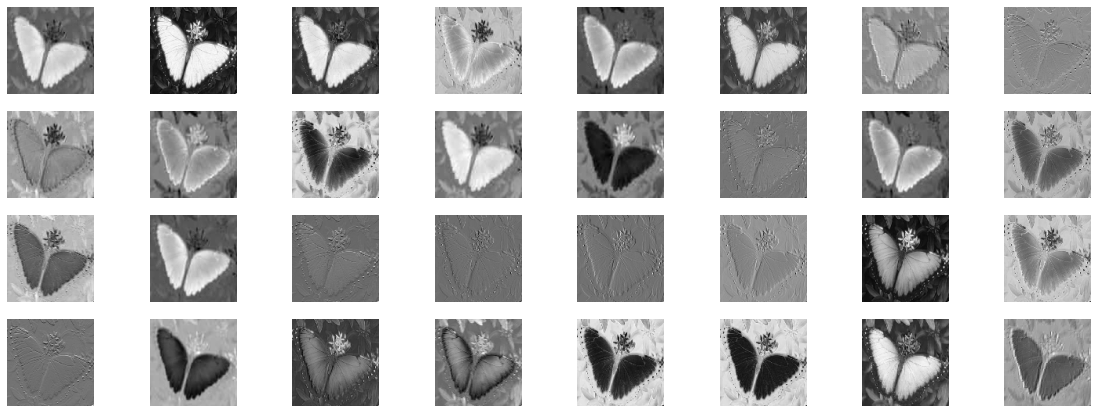

In [43]:
# Imagem a ser utilizada
IMAGE_PATH = "./data/raw-img/farfalla/OIP-_eNyV3DN2t677_34FjtCgQHaFj.jpeg"

# Modelo auxiliar para visualizar as decisões
view_model = Model(inputs=inception_model.inputs, outputs=inception_model.layers[1].output)

# Imagem a ser utilizada
image = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=IMAGE_SIZE)
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

# Extração de características e visualização
features = view_model.predict(image)
fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):
    plt.subplot(8,8,i)
    plt.axis("off")
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
plt.show()

1/1 [==============================] - 2s 2s/step


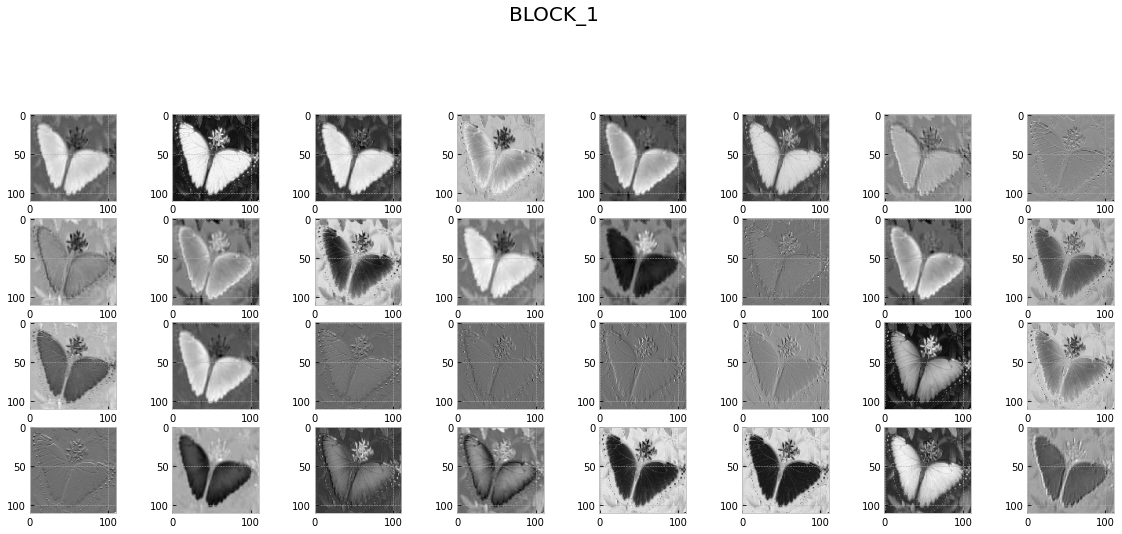

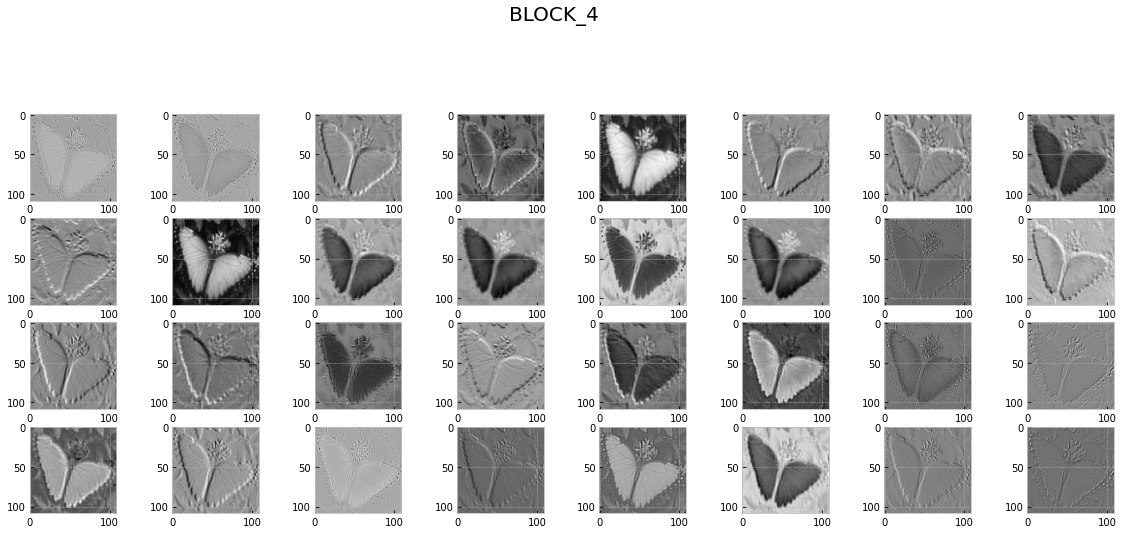

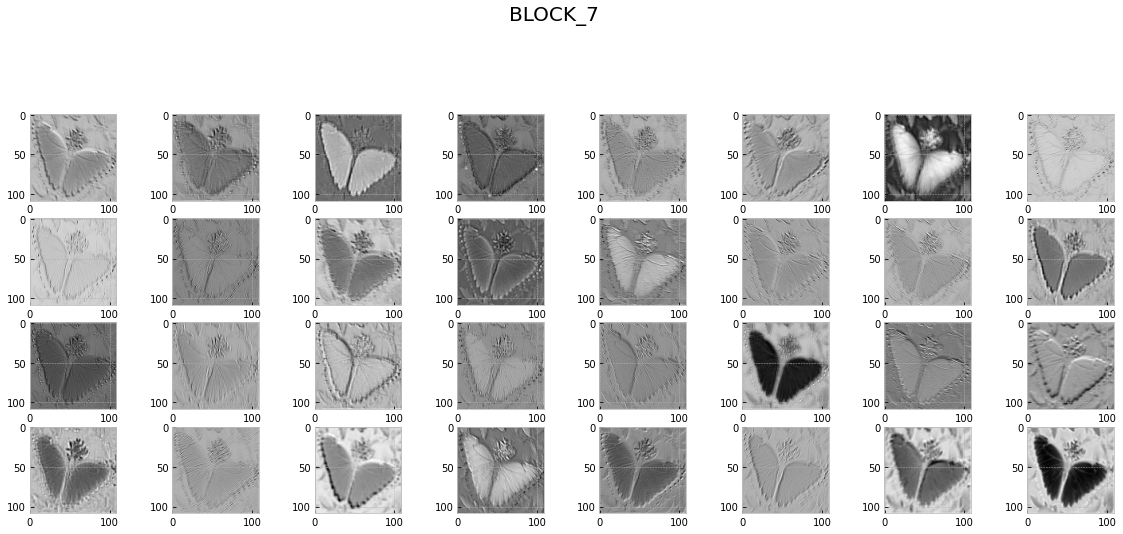

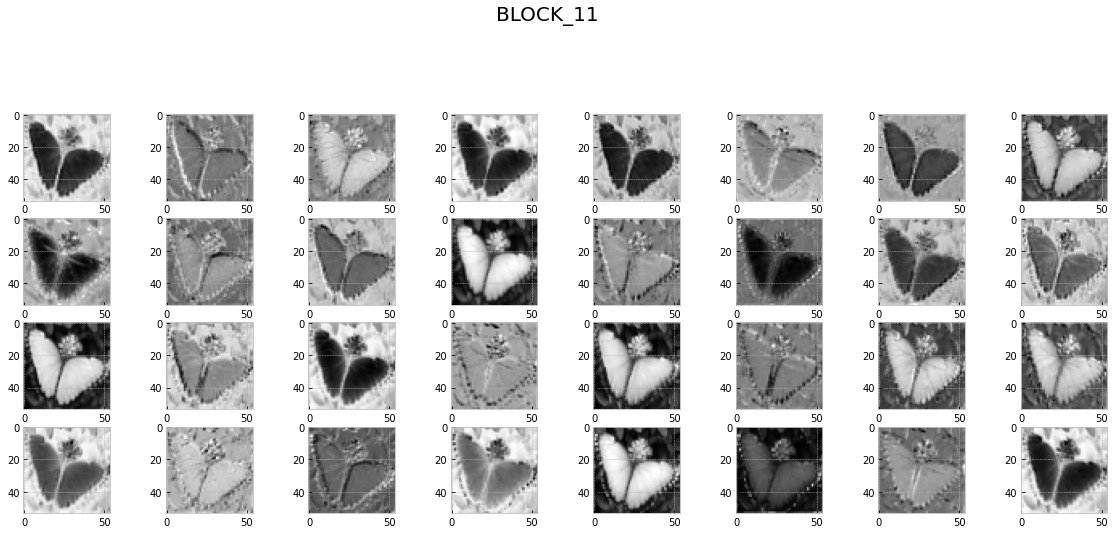

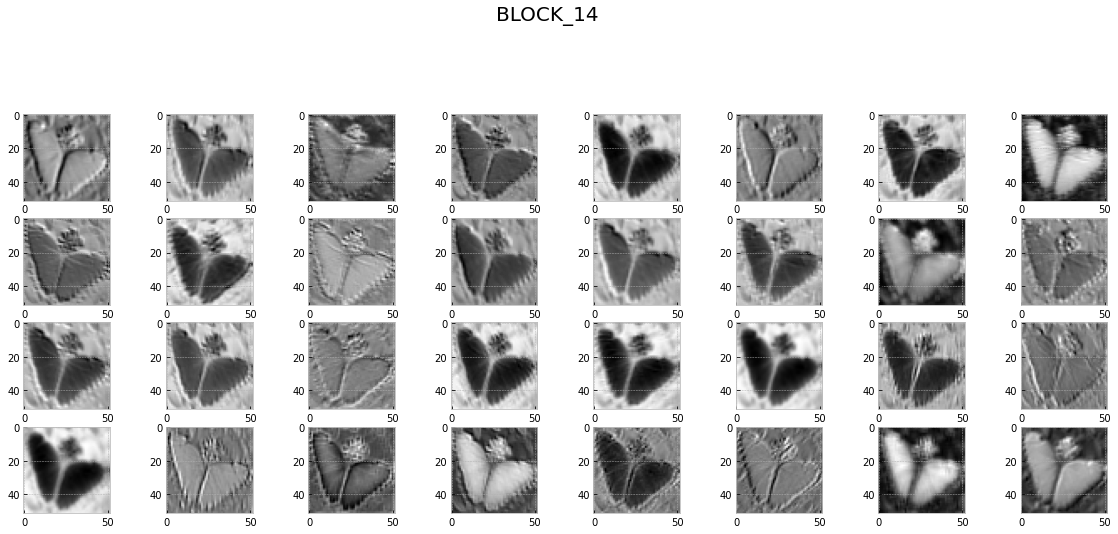

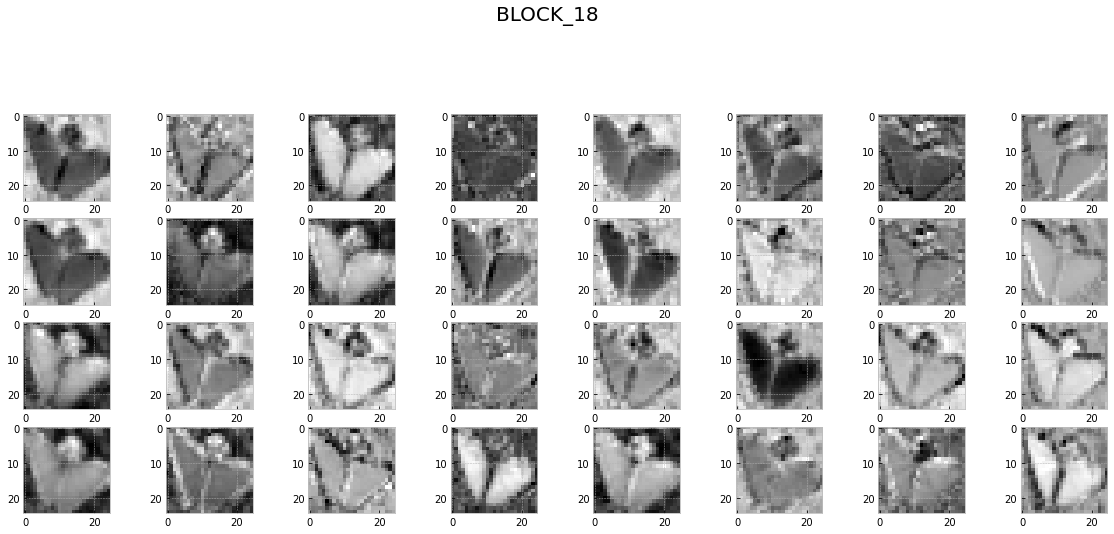

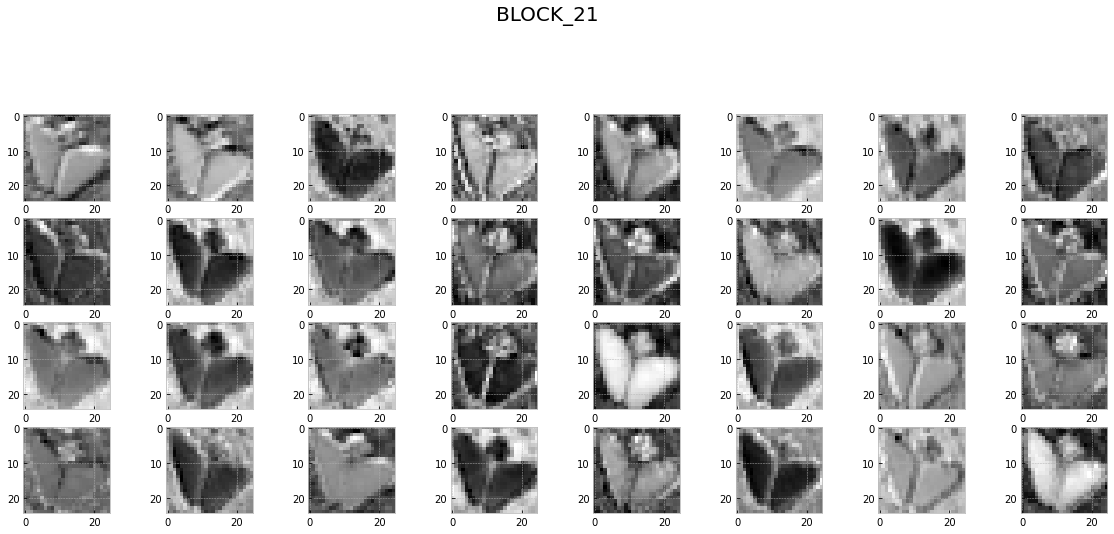

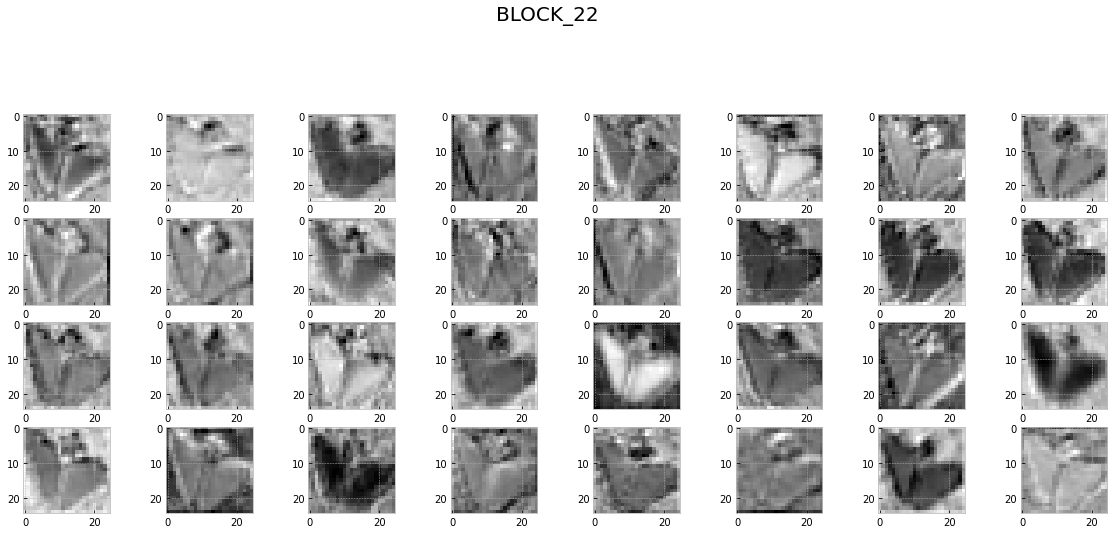

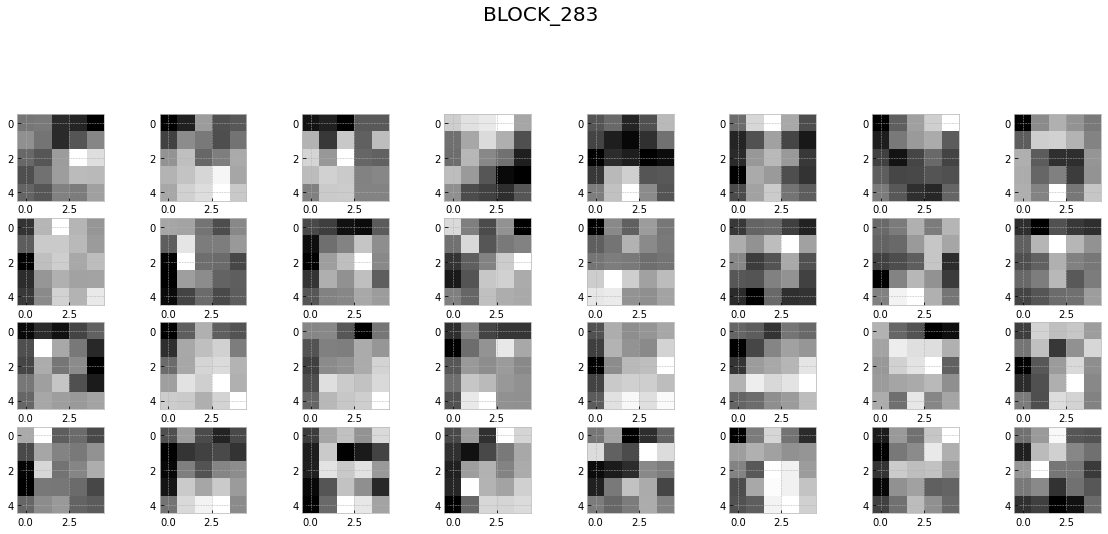

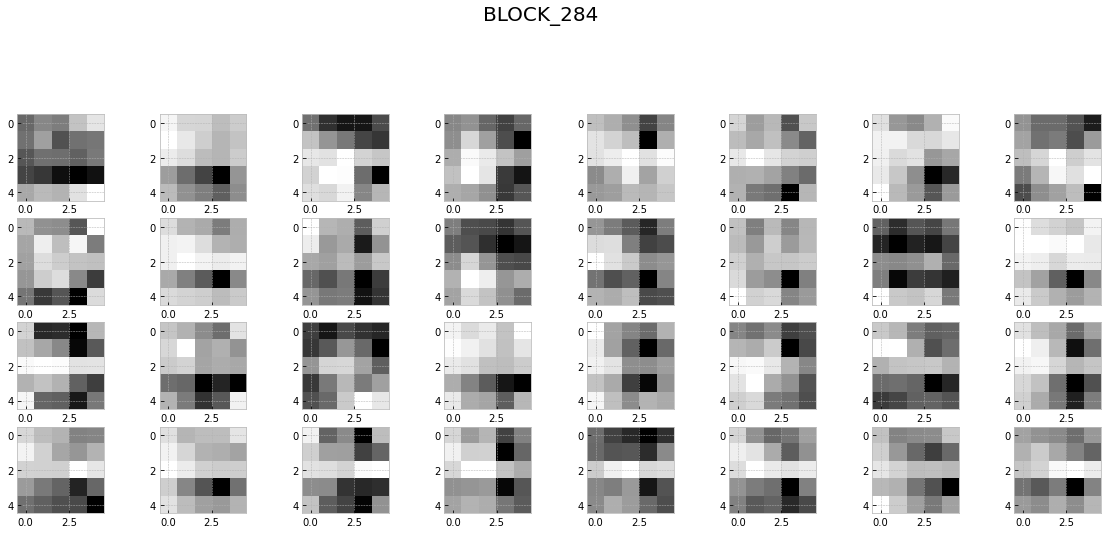

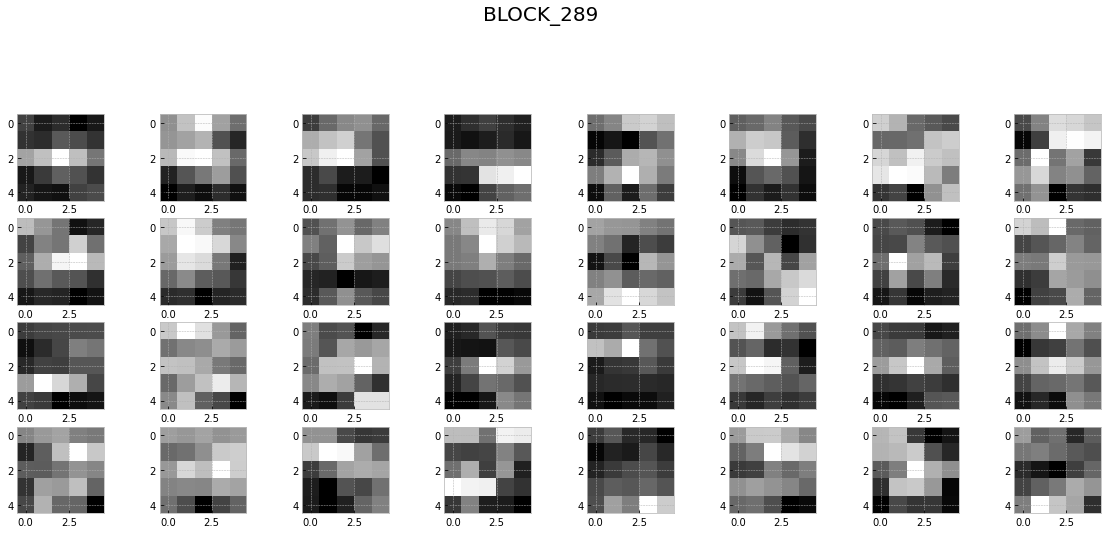

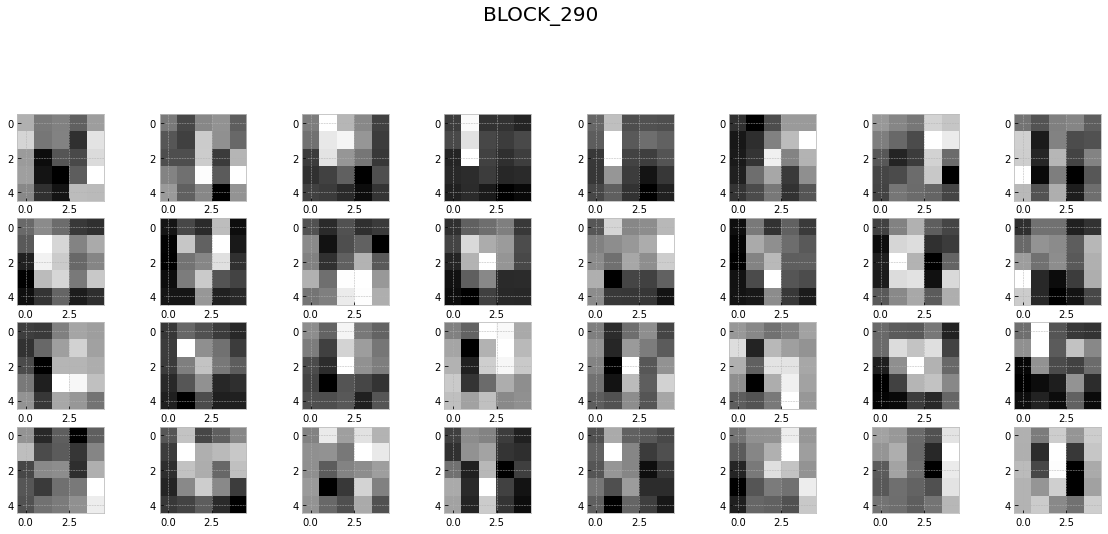

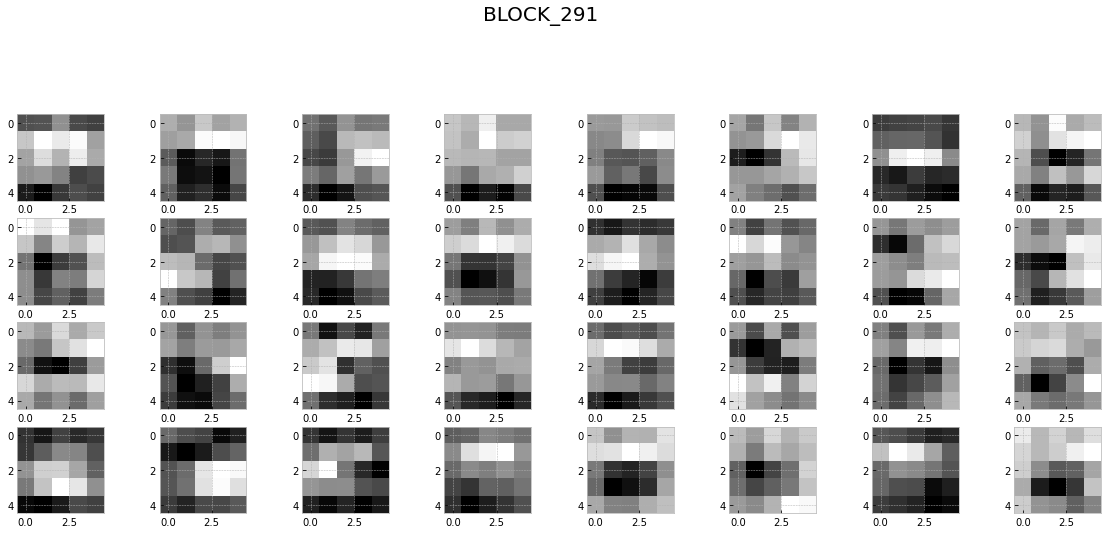

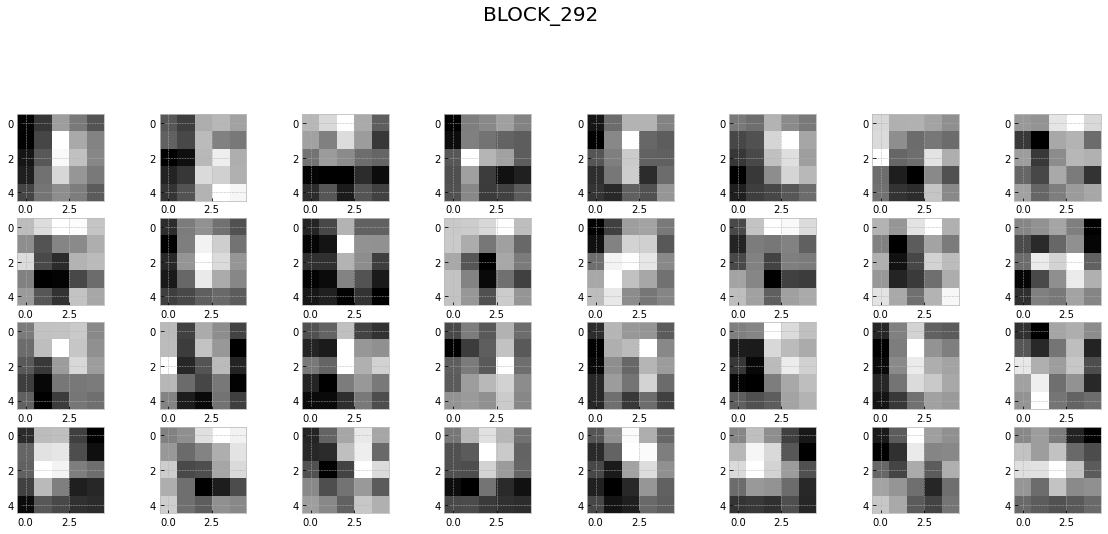

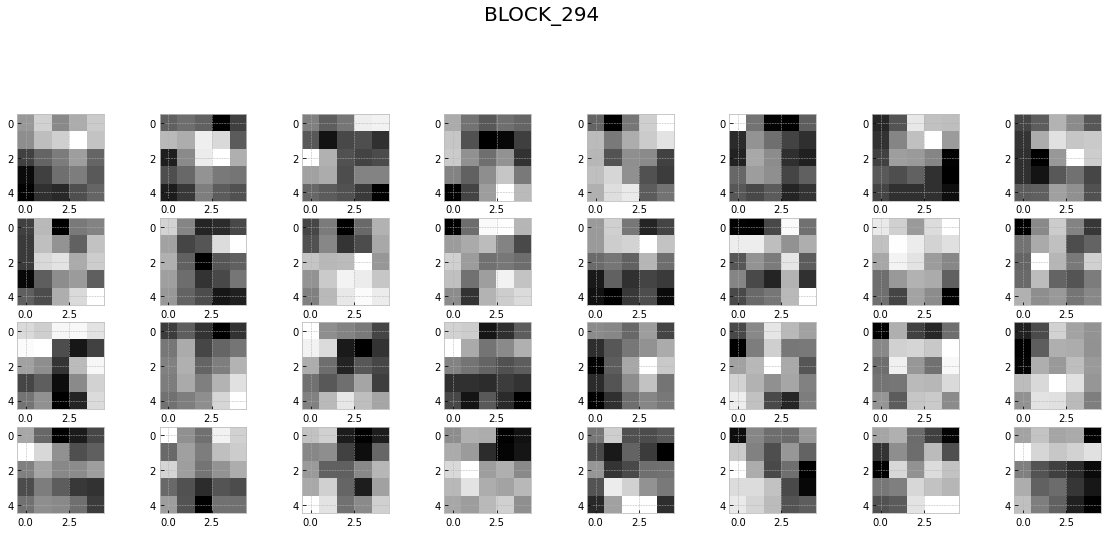

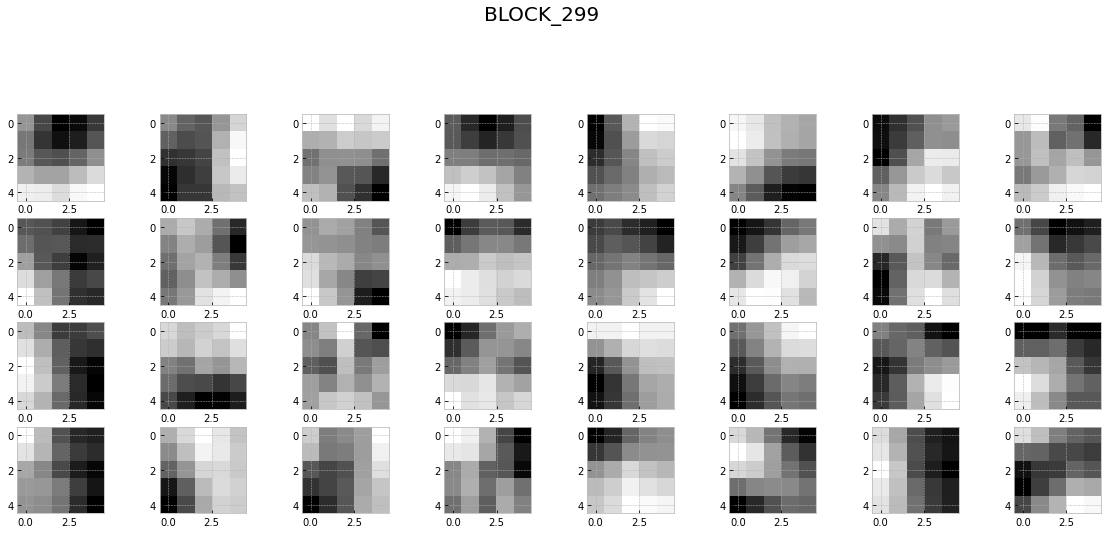

In [54]:
# Extração das camadas convolucionais e construção do modelo
conv_layers = []
for i, layer in enumerate(base_model.layers):
    if "conv" in layer.name:
        conv_layers.append(i)
head = conv_layers[:8] # Primeiras 8 camadas
tail = conv_layers[-8:] # Últimas 8 camadas
conv_layers = head + tail
outputs = [inception_model.layers[i].output for i in conv_layers]
view_model = Model(inputs=inception_model.inputs, outputs=outputs)

# Visualização
feature_map = view_model.predict(image)
for i, fmap in zip(conv_layers, feature_map):
    fig = plt.figure(figsize=(20,15))
    fig.suptitle("BLOCK_{}".format(i) , fontsize=20)
    for i in range(1,features.shape[3]+1):
        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i-1] , cmap='gray')   
plt.show()